In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv("Iris.csv")
data = data.sample(frac=1, random_state=42)

In [3]:
feature_columns = data.columns[:4]
feature_columns

Index(['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'], dtype='object')

In [4]:
def normalize(df):
    new_df = df.copy()
    for col in feature_columns:
        new_df[col] -= df[col].mean()
        new_df[col] /= df[col].std()
    return new_df

In [5]:
data_normalized = normalize(data)

In [6]:
categories = np.unique(data["Class"])
colors = ['red', 'yellow', 'blue']
colordict = dict(zip(categories, colors))  

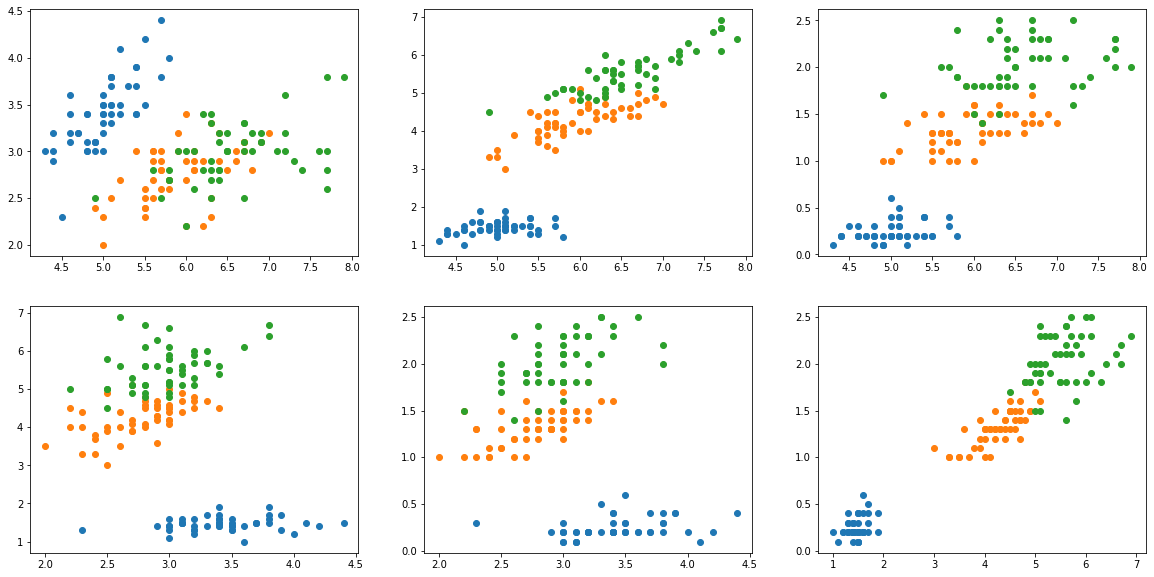

In [7]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flat
groups = data.groupby("Class")
columns = data.columns
plot_columns = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

for i,p in enumerate(plot_columns):
    for name, group in groups:
        axes[i].plot(group[columns[p[0]]], group[columns[p[1]]], marker="o", linestyle="", label=name)

In [8]:
def train_test_splitter(data_to_split):
    split_point =  int(0.8 * len(data_to_split))
    X_train = data_to_split.iloc[:split_point, [0,1,2,3]]
    y_train =  data_to_split.iloc[:split_point, [-1]]
    X_test = data_to_split.iloc[split_point:, [0,1,2,3]]
    y_test = data_to_split.iloc[split_point:, [-1]]
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_splitter(data)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_splitter(data_normalized)

In [9]:
class_idx = {}
for i,c in enumerate(categories):
    class_idx[c] = i
class_idx

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [10]:
def nn_classify(X_train, X_test, y_train, y_test):
    
    conf_mtx = np.zeros((3,3))
    corrects = 0
    
    for i, _ in X_test.iterrows():
        diffs = X_train.loc[:, feature_columns] - X_test.loc[i, feature_columns].squeeze(0)
        nearest_index = diffs.pow(2).sum(axis=1).idxmin()
        
        prediction = y_train.loc[nearest_index, 'Class']
        real_class = y_test.loc[i, 'Class']
        
        conf_mtx[class_idx[prediction]][class_idx[real_class]] += 1
        
        if prediction == y_test.loc[i, 'Class']:
            corrects += 1
        
    accuracy = corrects/len(X_test) * 100
    return accuracy, conf_mtx

In [11]:
accuracy, conf_mtx = nn_classify(X_train, X_test, y_train, y_test)

In [12]:
accuracy

96.66666666666667

In [13]:
accuracy, conf_mtx = nn_classify(X_train_normal, X_test_normal, y_train_normal, y_test_normal)

In [14]:
accuracy

96.66666666666667

In [15]:
precisions = []
recalls = []
f1 = []

In [16]:
for i in range(len(categories)):
    precision = conf_mtx[i][i] / conf_mtx.sum(axis=1)[i]
    precisions.append(precision)
    recall = conf_mtx[i][i] / conf_mtx.sum(axis=0)[i]
    recalls.append(recall)
    f1.append(2 * (precision * recall) / (precision + recall))

In [17]:
precisions

[1.0, 0.9166666666666666, 1.0]

In [18]:
recalls

[1.0, 1.0, 0.9166666666666666]

# Using Sklearn

In [19]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [20]:
data = pd.read_csv("Iris.csv")

In [21]:
X = data[feature_columns]
y = data['Class']
y = label_binarize(y, classes=y.unique())

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)

In [24]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

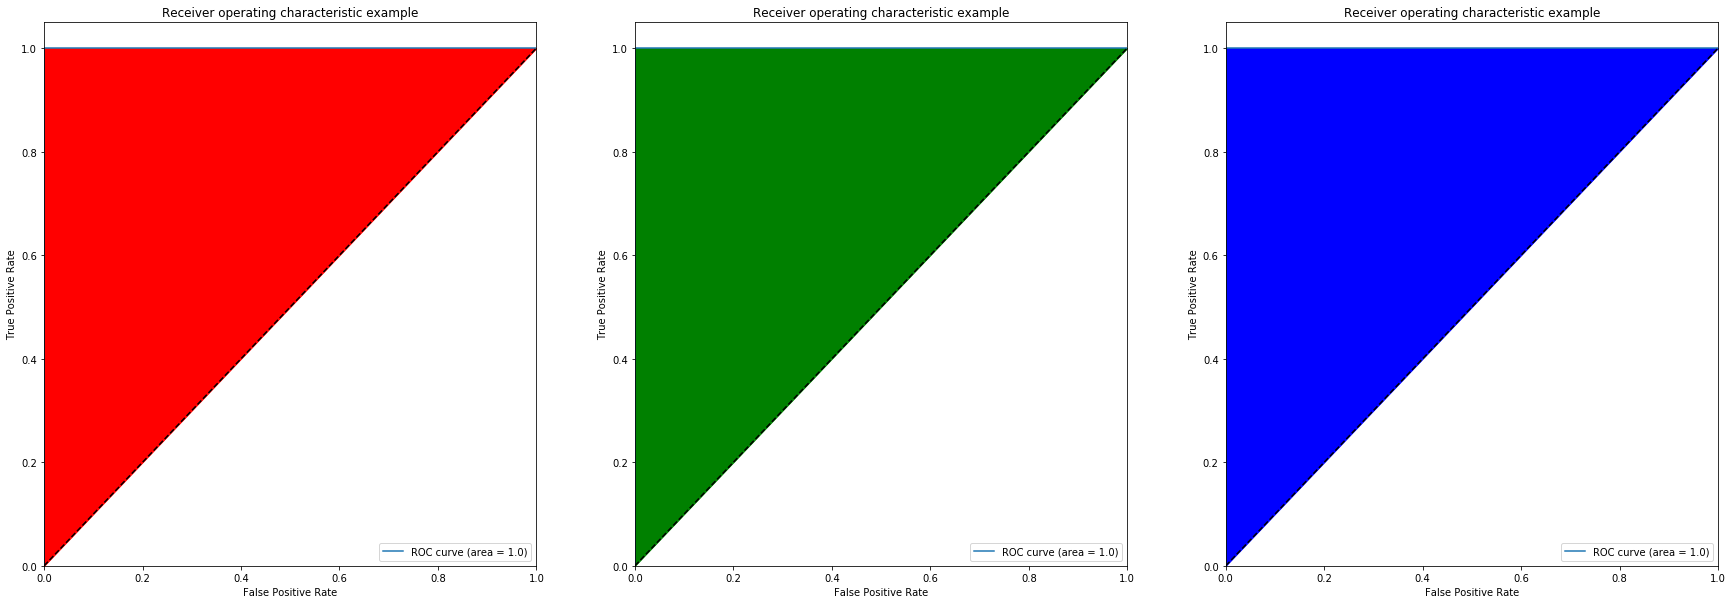

In [40]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig, axes = plt.subplots(1,3, figsize=(30,10))
axes = axes.flat
colors = ['r', 'g', 'b']
for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], label='ROC curve (area = {})'.format(roc_auc[i]))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].fill_between(fpr[i], fpr[i], tpr[i], 1, color=colors[i])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('Receiver operating characteristic example')
    axes[i].legend(loc="lower right")

In [ ]:
data_normalized = normalize(data)
X = data_normalized[feature_columns]
y = data_normalized['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

In [ ]:
y_pred = pd.DataFrame(knn.predict(X_test))

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
confusion = confusion_matrix(y_test, y_pred)
confusion